# Alpha Research Process

This notebook will provide an introduction to using our improved research infrastructure. While it does not go over all of the tooling available with our platform, it does provide the essential basics to get started with simple Alpha research. In summary, this notebook will first introduce the concept of `backtester` objects and their dynamic functionality with `Alpha` classes. Additionally, towards the end of the notebook, we will take a look at a few more advanced exploratory functions, which can be expanded upon in your own research.

In this first cell we simply import everything we will be using. Just to reiterate, this is not everything available, but will get us most of what we need for this simple notebook.

In [1]:
import os
os.chdir('..')
from infrastructure.backtesters import full_backtesters as fb
from infrastructure.alpha_eval import apply_metric_func
from siftools import sif_utils as su, operators as op, metrics
from siftools.abstractalpha import AbstractAlpha
os.chdir('examples')
import matplotlib.pyplot as plt
import datetime
plt.rcParams['figure.figsize'] = (15, 9)

In [2]:
import warnings
warnings.filterwarnings('ignore')  # Disable warnings to reduce output spam in notebook

In the following cell we construct our backtesting environment. This is easily done by providing a few parameters to the backtester constructor. Since we will be testing a variety of strategies in this example, I have opted to use the `FullMultipleBacktester` from the `full_backtesters` module to give us the ability to quickly backtest a group of alphas at once. We simply provide the start and end date of the backtest period, as well as universe rebalance dates, maximum lookback, universe size, and factors needed for research. In this demo we will look at the period from `2015-1-1` to `2020-1-1`. We will use quarterly, `'Q'`, universe rebalancing, however you can also provide custom dates, i.e. `[(1, 1), (4, 1), (7, 1), (10, 1)]` to rebalance on the first of January, April, July, and October. The maximum lookback I provided is `252`, which is approximately 1 year (~252 trading days per year), and a universe size of the top 500 equities at each universe rebalance date. Lastly, we provide a list of factors we would like to use in our consequential research. I included a bunch of simple factors, though we will only be looking into a couple of them.

Once you run this cell once, you may comment out the `backtester = fb.FullMultipleBacktester` and `backtester.save_local('alpha_research_data.npy')` lines, and uncomment `backtester = fb.FullMultipleBacktester.from_local('alpha_research_data.npy')` to load the data from local storage, which is much quicker for reusability.

In [3]:
start_date = datetime.datetime(2015, 1, 1)
end_date = datetime.datetime(2020, 1, 1)
backtester = fb.FullMultipleBacktester(
    start_date,
    end_date,
    'Q',
    252,
    500,
    ['open', 'close', 'assets', 'equity', 'netinc', 'gp', 'ncf', 'ebitdamargin', 'grossmargin', 'pb', 'sector']
)
backtester.save_local('alpha_research_data.npy')
# backtester = fb.FullMultipleBacktester.from_local('alpha_research_data.npy')
sp_data = su.get_sp_close(start_date, end_date)  # Also pull S&P data for use later
sp_ret = sp_data.pct_change()

Below is where the research really begins. Inheriting from `AbstractAlpha`, we can begin to construct a variety of signals using OOP design to give us great flexibility within our strategies. In the `__init__` methods we need to declare a few necessary variables, namely: `name`, `lookback`, `universe_size`, and `factor_list`. In most cases this would match the settings you already used above for the `backtester`, but it does provide more nuanced configuration of individual strategies if you so choose to. Furthermore, you should try to only include factors in  `factor_list` that are actually used in the strategy, this will reduce the memory used in backtesting, and overall speedup because less data is being passed around.

The following strategies are fairly simple, so I won't go to in-depth for this demo. The basic idea is weighting the raw `ROE` and `ROA` factor scores, as well as taking the change of `ROE` and `ROA` into consideration for the weighting. Z-scores are grouped into sectors, to avoid over weighting individual sectors. The final `FullStrategy` combines the signals from the first two strategies into one final weighting.

In [4]:
class RoeCombined(AbstractAlpha):
    def __init__(self):
        self.name = 'RoeCombined'
        self.lookback = 252
        self.universe_size = 500
        self.factor_list = ['netinc', 'equity', 'sector']
    
    def generate_day(self, day, data):
        roe = data['netinc'] / data['equity']
        change = op.group_zscore((roe[day] / roe[day - self.lookback]) - 1, data['sector'])
        raw = op.group_zscore(roe[day], data['sector'])
        factor = op.group_zscore(change + raw, data['sector'])
        return op.weight(factor)
    
    
class RoaCombined(AbstractAlpha):
    def __init__(self):
        self.name = 'RoaCombined'
        self.lookback = 252
        self.universe_size = 500
        self.factor_list = ['netinc', 'assets', 'sector']

    def generate_day(self, day, data):
        roa = data['netinc'] / data['assets']
        change = op.group_zscore((roa[day] / roa[day - self.lookback]) - 1, data['sector'])
        raw = op.group_zscore(roa[day], data['sector'])
        factor = op.group_zscore(change + raw, data['sector'])
        return op.weight(factor)

class FullStrategy(AbstractAlpha):
    def __init__(self):
        self.name = 'FullStrategy'
        self.lookback = 252
        self.universe_size = 500
        self.factor_list = ['netinc', 'assets', 'equity', 'sector']

    def generate_day(self, day, data):
        roe = data['netinc'] / data['equity']
        roa = data['netinc'] / data['assets']
        
        roe_change = op.group_zscore((roe[day] / roe[day - self.lookback]) - 1, data['sector'])
        roe_raw = op.group_zscore(roe[day], data['sector'])
        roe_factor = op.group_zscore(roe_change + roe_raw, data['sector'])
        
        roa_change = op.group_zscore((roa[day] / roa[day - self.lookback]) - 1, data['sector'])
        roa_raw = op.group_zscore(roa[day], data['sector'])
        roa_factor = op.group_zscore(roa_change + roa_raw, data['sector'])
        
        return op.weight(roe_factor + roa_factor)

To run the backtest now, all we need to do is instantiate an object from each Alpha strategy and create a list to throw into the backtest. Since we are working in a jupyter notebook, `processes` is set to `None` because multiprocessing will not work in a jupyter notebook. Nevertheless, backtesting these strategies should be relatively fast, only taking just over a minute in my case.

In [5]:
alphas = [
    RoeCombined(),
    RoaCombined(),
    FullStrategy()
]
returns, holdings = backtester.backtest(alphas, processes=None)

3it [01:06, 22.23s/it]


To see the cumulative performance of these strategies, we can apply a cumulative sum to the returns, and plot the graph over time, while using the S&P500 data as a performance benchmark.

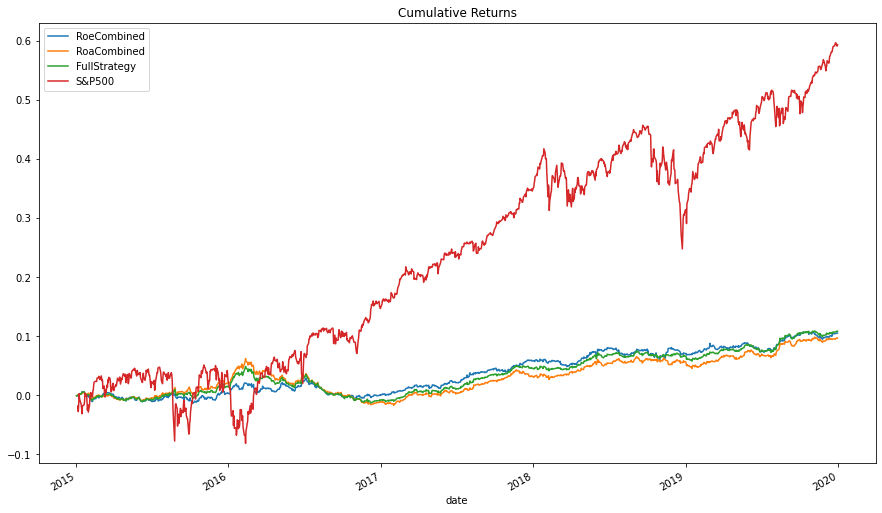

In [6]:
returns.cumsum().plot()
sp_ret.cumsum().plot(label='S&P500')
plt.legend(labels=['RoeCombined', 'RoaCombined', 'FullStrategy', 'S&P500'])
plt.title('Cumulative Returns')
plt.show()

We can also use a tool to produce a summary plot of the different strategies so we can see how they vary individually over time.

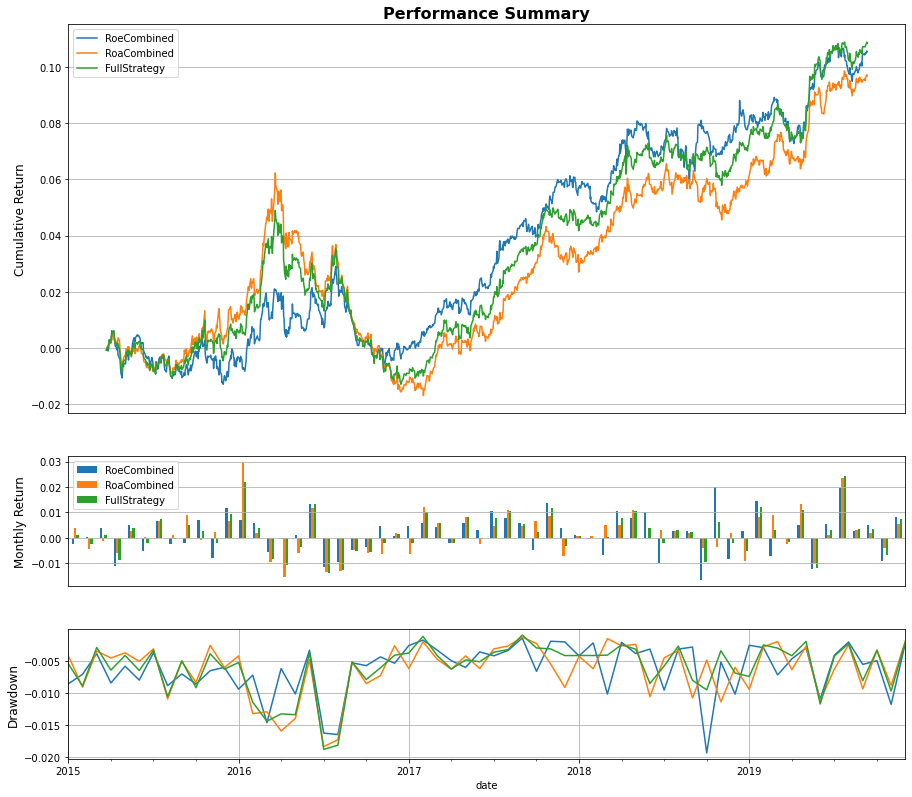

In [7]:
metrics.summary_plot(returns, source=['RoeCombined', 'RoaCombined', 'FullStrategy'])

We can also couple the `apply_metric_func` from `alpha_eval` and `generate_performance_table` from `metrics` to produce a small dataframe of summary analytics for each strategy, to more closely compare their performance.

In [8]:
from IPython.core import display as ICD
perf_tables = apply_metric_func(metrics.generate_performance_table, ('daily_returns', 'holdings'))(returns, holdings)
for alpha, table in zip(alphas, perf_tables):
    print(f"{alpha.name}")
    ICD.display(table)
    print()

RoeCombined


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2015,0.003378,0.136090,0.210107,-0.018928,0.028706,208.341270,288.416667
2016,-0.003415,-0.122994,-0.185474,-0.033938,0.027630,246.563492,250.555556
2017,0.057988,3.104750,4.883730,-0.006303,0.022488,250.470120,247.000000
2018,0.012745,0.438221,0.749498,-0.021404,0.028903,263.557769,235.597610
2019,0.034716,1.475069,2.568157,-0.016100,0.027675,233.341270,266.714286
Overall,0.105412,0.840533,1.328987,-0.033827,0.028317,240.428458,257.682830



RoaCombined


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2015,0.019355,0.813464,1.242457,-0.014812,0.024427,227.928571,268.829365
2016,-0.029978,-0.895001,-1.441945,-0.074665,0.023958,229.031746,268.087302
2017,0.043088,2.209973,3.604511,-0.010989,0.023303,218.569721,278.900398
2018,0.024345,0.974436,1.423787,-0.013329,0.029867,218.537849,280.617530
2019,0.039963,1.633903,2.899818,-0.012649,0.026206,224.865079,275.190476
Overall,0.096773,0.753033,1.163027,-0.074513,0.026523,223.794913,274.316375



FullStrategy


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2015,0.014205,0.611710,0.906042,-0.016391,0.026719,227.964286,268.793651
2016,-0.022178,-0.703997,-1.127526,-0.059774,0.025635,230.325397,266.793651
2017,0.053804,2.881875,4.598922,-0.006725,0.023338,222.338645,275.131474
2018,0.020739,0.868589,1.460041,-0.012410,0.030092,222.027888,277.127490
2019,0.041843,1.812971,3.242319,-0.013429,0.027686,222.154762,277.900794
Overall,0.108412,0.885843,1.391727,-0.058965,0.027760,224.966614,273.144674


If you would like to do even more advanced research, you may find the code below useful. We can apply a rolling metric using `metrics.rolling_metric`. In this example I show how we can use this to create a rolling 1-year Sharpe Ratio, leveraging `functools.partial` so I can `apply` it to all the strategies in our returns dataframe.

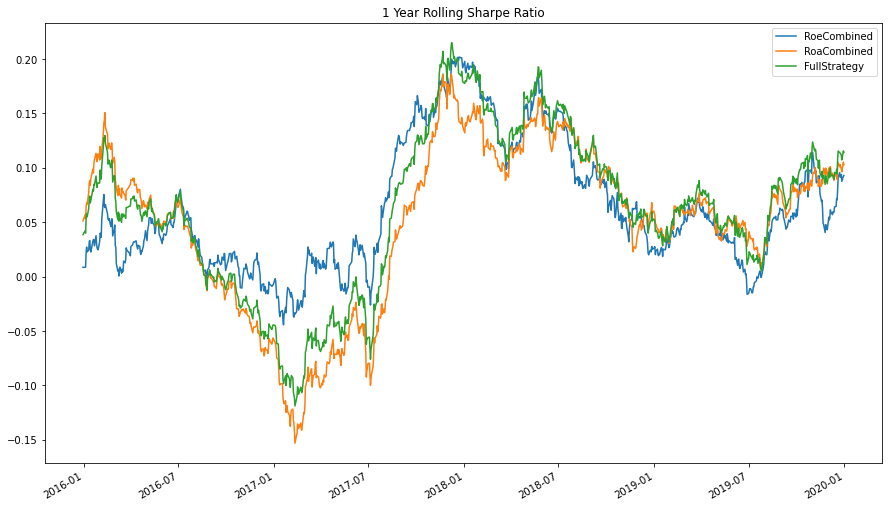

In [9]:
import functools
rolling_sharpe = functools.partial(metrics.rolling_metric, func=metrics.sharpe_ratio, window=252)
returns.apply(rolling_sharpe).plot()
plt.title('1 Year Rolling Sharpe Ratio')
plt.show()

Similarly, we can show a 3-year rolling beta (correlation against benchmark), using the S&P returns data as a benchmark.

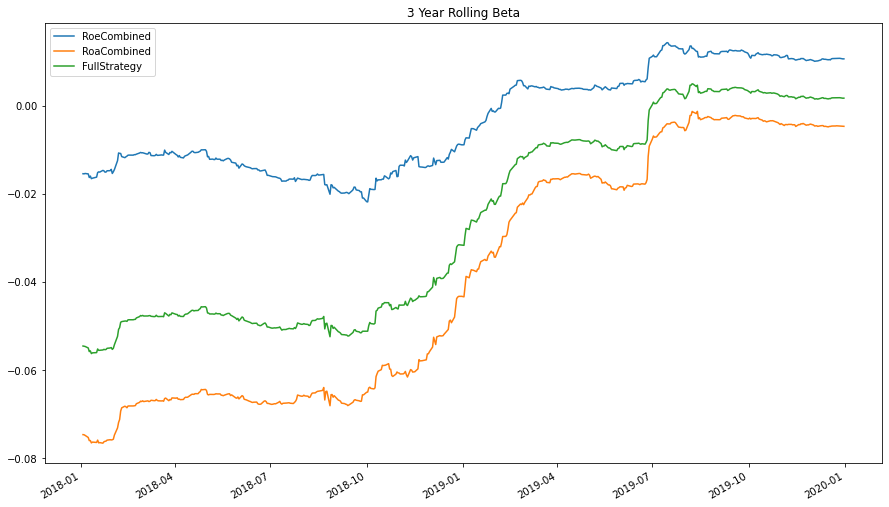

In [10]:
rolling_beta = functools.partial(metrics.rolling_metric, func=metrics.beta, window=252*3, benchmark_data=sp_ret)
returns.apply(rolling_beta).plot()
plt.title('3 Year Rolling Beta')
plt.show()

Obviously this leaves a lot of room for other analytical approaches, but hopefully this has provided a solid foundation for diving straight into alpha research, with all the tools available to find viable strategies in today's markets. I hope you have enjoyed this demo, and if you have any feedback, please feel free to reach the team at: contact@smithinvestmentfund.com